In [38]:
pwd

'/gpfs/alpine/bif135/proj-shared/rbd_work/dask_testing/tmalign_andes_workflow/testing_runs/test8'

In [39]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from matplotlib import cm
import itertools
import numpy as np
import pandas
from datetime import datetime
import copy
from pathlib import Path

In [40]:
temp_dict = {'batch_start': 0,
             'batch_end': 0, 
             'client_start': 0,
             'client_end': 0, 
             'total_time': 0., 
             'client_start_overhead': [], 
             'worker_between_overhead': [], 
             'worker_idle_times': [],
             'stop_overhead': 0}

In [41]:
node_dict = {}

In [42]:
subdir = '.'
node_dict[subdir] = copy.deepcopy(temp_dict)

start_time   = 'Thu Sep 8 11:36:45 EDT 2022'
end_time     = 'Thu Sep 8 11:37:05 EDT 2022'

st = datetime.strptime(start_time, "%a %b %d %H:%M:%S %Z %Y")
et = datetime.strptime(end_time,   "%a %b %d %H:%M:%S %Z %Y")
total_time = (et - st).total_seconds()
print(st.timestamp(),et.timestamp(),total_time)

node_dict[subdir]['batch_start']  = 0
node_dict[subdir]['batch_end']    = et.timestamp() - st.timestamp()
node_dict[subdir]['client_start'] = 1662651408.2882888 - st.timestamp()
node_dict[subdir]['client_end']   = 1662651425.49647 - st.timestamp()

print(node_dict[subdir]['batch_start'],node_dict[subdir]['batch_end'],node_dict[subdir]['client_start'],node_dict[subdir]['client_end'])

1662651405.0 1662651425.0 20.0
0 20.0 3.2882888317108154 20.496469974517822


In [43]:
df = pandas.read_csv(f'{subdir}/timings.csv', sep=',')
df['start_time'] -= st.timestamp()
df['stop_time']  -= st.timestamp()
df = df.sort_values(by = ['start_time'])
print(df)

                  hostname                                    worker_id  \
9   andes683.olcf.ornl.gov  Worker-0f28497f-1a74-4c23-b59b-6f083f3a0778   
8   andes683.olcf.ornl.gov  Worker-3d7d82c0-471f-4f3c-92f8-41b1ca446683   
5   andes683.olcf.ornl.gov  Worker-cb7ee8fc-5205-4bee-add9-958bdaf032e3   
6   andes683.olcf.ornl.gov  Worker-80d29570-06eb-4dbf-be38-629c333c2c54   
7   andes683.olcf.ornl.gov  Worker-ff9243ac-1243-45b2-af7d-3ccfe1dd7059   
13  andes683.olcf.ornl.gov  Worker-037a3002-a905-45a2-9755-6bb8691dc953   
3   andes683.olcf.ornl.gov  Worker-3a93066a-4400-4cc1-a55e-35f4f4d7eed8   
1   andes683.olcf.ornl.gov  Worker-6ac253ff-ee85-4d73-b956-82601c99fa41   
2   andes683.olcf.ornl.gov  Worker-f8ec6fb9-0984-4e0c-b293-cab6d51d02d4   
0   andes683.olcf.ornl.gov  Worker-d8d7188a-0cb6-48c0-a949-5f86567c8b80   
4   andes683.olcf.ornl.gov  Worker-24cd8da5-a139-439b-8ecd-a27f3f72e118   
15  andes683.olcf.ornl.gov  Worker-d8d7188a-0cb6-48c0-a949-5f86567c8b80   
14  andes683.olcf.ornl.go

In [44]:
workers = list(set(df['worker_id']))

worker_client_startup_overheads = []
worker_between_overheads = []
worker_idle_times = []
for worker in workers:
    worker_tasks = df[df['worker_id'] == worker]
    a = np.min(worker_tasks['start_time']) - node_dict[subdir]['client_start']
    b = node_dict[subdir]['client_end'] - np.max(worker_tasks['stop_time'])
    worker_client_startup_overheads.append(a)
    worker_idle_times.append(b)
    between_time = 0
    for i in range(len(worker_tasks)-1):
        between_time += worker_tasks.iloc[i+1]['start_time'] - worker_tasks.iloc[i]['stop_time']
    worker_between_overheads.append(between_time)
        
node_dict[subdir]['client_start_overhead'].append(worker_client_startup_overheads)
node_dict[subdir]['worker_idle_times'].append(worker_idle_times)
node_dict[subdir]['worker_between_overhead'].append(worker_between_overheads)

print([node_dict[subdir]['batch_end'],node_dict[subdir]['client_end'],np.max(df['stop_time'])])
total_time = np.max([node_dict[subdir]['batch_end'],node_dict[subdir]['client_end'],np.max(df['stop_time'])])
node_dict[subdir]['total_time'] = total_time
node_dict[subdir]['stop_overhead'] = total_time - np.max(df['stop_time'])
#preprocessing_dt = df['stop_time'] - df['start_time'] if df['task'] == 'preprocessing'

[20.0, 20.496469974517822, 20.493471145629883]


In [45]:
worker_dict = {}
count = 0
for worker in df.iloc:
    if worker['worker_id'] not in worker_dict.keys():
        worker_dict[worker['worker_id']] = count
        count += 1
print(count)

11


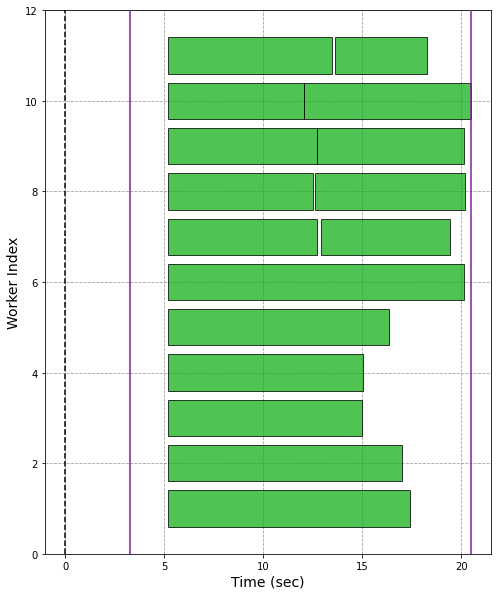

In [46]:
colormap = cm.Dark2.colors
figure = plt.figure(figsize=(8,10))
ax = plt.gca()
ax.plot([0,0],[0,count+1],'k--',zorder=3)
ax.plot([node_dict[subdir]['client_start'],node_dict[subdir]['client_start']],[0,count+1],'-',c='xkcd:purple',zorder=3)
ax.plot([total_time,total_time],[0,count+1],'-',c='xkcd:purple',zorder=3)

for task in df.iloc:
    worker_id = worker_dict[task['worker_id']]
    if task['return_code'] == 0:
        facecolor = 'xkcd:green'
    else:
        facecolor='xkcd:red'
    task_rect = Rectangle((task['start_time'], worker_id + 0.6), # xy
                           task['stop_time']-task['start_time'], # width
                           0.8, # height
                           facecolor = facecolor,
                           alpha = 0.75, edgecolor = 'xkcd:black', zorder = 3)
    ax.add_patch(task_rect)

ax.set_ylim((0.,count+1))
ax.set_ylabel('Worker Index',size=14)
ax.set_xlabel('Time (sec)',size=14)
plt.grid(b=True,which='major',axis='both',color='#808080',linestyle='--',alpha=0.75,zorder=1)
plt.savefig(f'{subdir}/worker_timeline.png',dpi=600,transparent=True)
plt.show()
plt.close()

In [47]:
print(node_dict[subdir].keys())
print(node_dict[subdir]['batch_start'])
print(node_dict[subdir]['batch_end'])
print(node_dict[subdir]['client_start'])
print(node_dict[subdir]['client_end'])
print(node_dict[subdir]['total_time'])
for i in node_dict[subdir]['client_start_overhead']:
    print(np.mean(i),np.std(i),len(i))
for i in node_dict[subdir]['worker_between_overhead']:
    print(np.mean(i),np.std(i),len(i))
for i in node_dict[subdir]['worker_idle_times']:
    print(np.mean(i),np.std(i),len(i))
print(node_dict[subdir]['stop_overhead'])

dict_keys(['batch_start', 'batch_end', 'client_start', 'client_end', 'total_time', 'client_start_overhead', 'worker_between_overhead', 'worker_idle_times', 'stop_overhead'])
0
20.0
3.2882888317108154
20.496469974517822
20.496469974517822
1.9020629579370671 0.00016556999065715875 11
0.04728687893260609 0.07406935959447739 11
2.355495496229692 2.002700045251592 11
0.002998828887939453
